In [1]:
# the following fixes are highly recommended

#allow oversubscription for openMPI
import os
os.environ["OMPI_MCA_rmaps_base_oversubscribe"]="true"

# use lower cpu resources for idle codes
from amuse.support import options
options.GlobalOptions.instance().override_value_for_option("polling_interval_in_milliseconds", 10)


## Set up the amuse simulation
This file will be used to test the validity of the BT_optimizer. We will first assume circular orbits.

In [2]:
# imports
from amuse.units import units, constants
from amuse.lab import Particles, Particle
import matplotlib.pyplot as plt
import numpy as np
from amuse.community.brutus.interface import Brutus 
from amuse.units import nbody_system
import tqdm

In [3]:
# define some basic functions
def relative_orbital_velocity(mass, distance):
    return (constants.G * mass / distance).sqrt()

def hill_radius(M, m, a):
    return a * (m / (3 * M))**(1/3)

def plot_system(system, velocities=True, title='System'):
    fig, ax = plt.subplots()
    for particle in system:
        ax.plot(particle.x.value_in(units.AU), particle.y.value_in(units.AU), 'o')
    if velocities:
        for particle in system:
            ax.quiver(particle.x.value_in(units.AU), particle.y.value_in(units.AU), particle.vx.value_in(units.AU / units.day), particle.vy.value_in(units.AU / units.day))
    ax.set_aspect('equal')
    ax.set_xlabel('x [AU]')
    ax.set_ylabel('y [AU]')
    ax.set_title(title)
    plt.show()


In [4]:
# first generate a single 3 body system to test the Brutus code
masses = [1.0, 10e-4, 10e-5, 10e-6, 10e-7, 10e-8, 10e-9] | units.MSun


def generate_n_body_system(n, masses=masses, phaseseed=42, center=True):
    '''
    Generate a system of n bodies with given masses and phases. The first body is a star, the rest are planets.
    The masses of the planets are given in the masses list, the mass of the star is 1 MSun. 
    By phase, we mean how far along in their orbits the planets start.

    :param int n: int, the number of bodies in the system
    :param list masses: list of floats, the masses of the planets in MSun
    :param phaseseed: seed to generate the phases of the planets
    '''
    # create the phases
    np.random.seed(phaseseed)
    phases = np.random.rand(n) * 2 * np.pi

    system = Particles(n)
    system.mass = masses[:n]
    system.name = ['star'] + ['planet{}'.format(i) for i in range(1, n)]
    # set the star parameters
    system[0].position = (0, 0, 0) | units.AU
    system[0].velocity = (0, 0, 0) | units.kms
    # set the planet parameters. Calculate the distances based on the Hill radii
    distance = []
    for i in range(1, n):
        if i == 1:
            distance.append(1 | units.AU)
        else:
            distance.append(distance[-1] + 10 * hill_radius(system[0].mass, system[i].mass, distance[-1]))
    # set the positions and velocities
    for i in range(1, n):
        r = distance[i-1].value_in(units.AU)
        system[i].position = (r * np.cos(phases[i-1]), r * np.sin(phases[i-1]), np.random.uniform(-0.001, 0.001)) | units.AU
        vorb = relative_orbital_velocity(system.total_mass(), distance[i-1]).value_in(units.kms)
        system[i].velocity = (-vorb * np.sin(phases[i-1]), vorb * np.cos(phases[i-1]), np.random.uniform(-0.01, 0.01)) | units.kms
    # center the system
    if center:
        system.move_to_center()
    return system



['star' 'planet1' 'planet2' 'planet3']


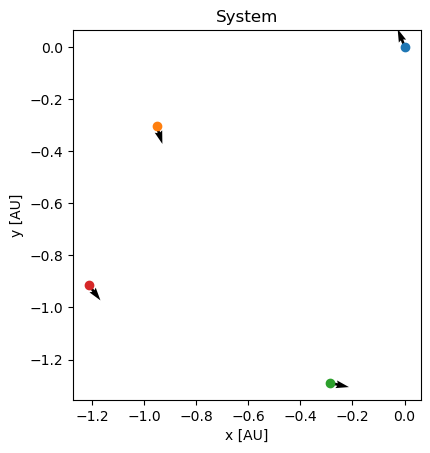

In [6]:
test_system = generate_n_body_system(4, phaseseed=0)
print(test_system.name)
plot_system(test_system)

Cool! Now we'd like to generate 100 of these systems, and evolve them by integrating them for a certain time. This time will have to be chosen in tandem with the BT optimizer.

In [8]:
# first initialize 100 systems with 3 planets each
def create_systems(n_systems, n_planets, masses=masses):
    '''
    Create n_systems systems with n_planets planets each. The masses of the planets are given in the masses.

    :param int n_systems: the number of systems to create
    :param int n_planets: the number of planets in each system
    :param list masses: list of floats, the masses of the planets in MSun
    '''
    systems = []
    for i in range(n_systems):
        system = generate_n_body_system(n_planets, masses, phaseseed=i)
        systems.append(system)
    return systems

def evolve_systems(systems, end_time, n_steps, converter=nbody_system.nbody_to_si(1 | units.Msun, 1 | units.AU),
                   plot=False, save_states=False):
    '''
    Evolve the systems to end_time in n_steps steps.

    :param list systems: list of Particles objects, the systems to evolve
    :param float end_time: the time to evolve to in days
    :param int n_steps: the number of steps to take
    '''
    
    # create a numpy array to store all the states' positions and velocities
    all_states = np.zeros((len(systems), n_steps+1, len(systems[0]), 6))
    # store the initial states in the first row
    all_states[:, 0, :, :] = np.array([[particle.x.value_in(units.AU), particle.y.value_in(units.AU),\
                                        particle.z.value_in(units.AU), particle.vx.value_in(units.AU / units.day),\
                                        particle.vy.value_in(units.AU / units.day), particle.vz.value_in(units.AU / units.day)] for particle in systems[0]])
    for sys_idx, system in enumerate(systems):
        gravity = Brutus(converter)
        gravity.particles.add_particles(system)
        channel = gravity.particles.new_channel_to(system)
        stepsize = end_time.value_in(units.day) / n_steps
        times = np.arange(0, end_time.value_in(units.day)+stepsize, stepsize)[1:]
        for time_idx, time in enumerate(times):
            gravity.evolve_model(time | units.day)
            channel.copy()
            if plot:
                fig, ax = plt.subplots()
                for particle in system:
                    ax.plot(particle.x.value_in(units.AU), particle.y.value_in(units.AU), 'o')
                for particle in system:
                    ax.quiver(particle.x.value_in(units.AU), particle.y.value_in(units.AU), particle.vx.value_in(units.AU / units.day), particle.vy.value_in(units.AU / units.day))
                ax.set_aspect('equal')
                ax.set_xlabel('x [AU]')
                ax.set_ylabel('y [AU]')
                ax.set_title('system {}'.format(sys_idx))
                plt.show()
            if save_states:
                for part_idx, particle in enumerate(system):
                    all_states[sys_idx, time_idx+1, part_idx] = np.array([particle.x.value_in(units.AU), particle.y.value_in(units.AU),\
                                                          particle.z.value_in(units.AU), particle.vx.value_in(units.AU / units.day),\
                                                          particle.vy.value_in(units.AU / units.day), particle.vz.value_in(units.AU / units.day)])

    gravity.stop()
    return systems, all_states

def plot_trajectory(system, states):
    fig, ax = plt.subplots()
    for particle in system:
        ax.plot(particle.x.value_in(units.AU), particle.y.value_in(units.AU), 'o')
    for particle in system:
        ax.quiver(particle.x.value_in(units.AU), particle.y.value_in(units.AU), particle.vx.value_in(units.AU / units.day), particle.vy.value_in(units.AU / units.day))
    ax.set_aspect('equal')
    ax.set_xlabel('x [AU]')
    ax.set_ylabel('y [AU]')
    ax.set_title('system')
    # plot the starting point of the system
    ax.plot(states[0, :, 0], states[0, :, 1], 'o', color='red', label='starting positions')
    ax.legend()
    ax.plot(states[:,:,0], states[:,:,1], color='black', alpha=0.2)
    plt.show()

In [7]:
converter = nbody_system.nbody_to_si(1 | units.MSun, 1 | units.AU)
print("for this particular converter:")
print(
    f"  The gravitational constant G in nbody units is: {converter.to_nbody(constants.G)}. "
    "Note that this is not unitless!")
print(f"  1 day is {converter.to_nbody(1. | units.day)} in nbody units")
print(f"  1 nbody time corresponds to {converter.to_si(1 | nbody_system.time)} in SI units")

for this particular converter:
  The gravitational constant G in nbody units is: 1.0 length**3 * mass**-1 * time**-2. Note that this is not unitless!
  1 day is 0.0172042796415 time in nbody units
  1 nbody time corresponds to 5022006.25661 s in SI units


In [9]:
# initialize the systems
n_bodies = 4
n_systems = 4
systems = create_systems(n_systems, n_bodies)
print('finished creating systems')

evolve_time = 10 | units.day
n_steps = 5
stepsize = (evolve_time / n_steps).value_in(units.day)

systems_evolved, all_states  = evolve_systems(systems, evolve_time, n_steps, plot=False, save_states=True)
print('finished evolving systems')
print(all_states.shape)
print(all_states[0])

finished creating systems


[MacBook-Pro-3.local:39459] shmem: mmap: an error occurred while determining whether or not /var/folders/5w/pthft8q53_924502fx0_8m800000gn/T//ompi.MacBook-Pro-3.501/jf.0/2449604608/sm_segment.MacBook-Pro-3.501.92020000.0 could be created.


finished evolving systems
(4, 6, 4, 6)
[[[  9.93047191e-04   4.39606397e-04   1.55726847e-07  -6.73529371e-06
     1.68282559e-05  -2.12193472e-09]
  [ -9.52340733e-01  -3.01478764e-01  -1.52534674e-04   5.19043482e-03
    -1.63936930e-02   1.68309608e-06]
  [ -2.85820117e-01  -1.28989842e+00  -1.24669851e-04   1.46088961e-02
    -3.23189837e-03   4.52323489e-06]
  [ -1.21244459e+00  -9.13779096e-01   9.27481248e-04   8.39692804e-03
    -1.11373095e-02  -1.34848505e-06]]

 [[  9.79005221e-04   4.73043039e-04   1.51391705e-07  -7.30546547e-06
     1.66051337e-05  -2.21282838e-09]
  [ -9.41397603e-01  -3.34081011e-01  -1.49078744e-04   5.75161492e-03
    -1.62053338e-02   1.77249288e-06]
  [ -2.56531553e-01  -1.29603059e+00  -1.15592165e-04   1.46784137e-02
    -2.90001140e-03   4.55406238e-06]
  [ -1.19544626e+00  -9.35896914e-01   9.24625627e-04   8.60091820e-03
    -1.09798778e-02  -1.50707311e-06]]

 [[  9.63830396e-04   5.06014004e-04   1.46877087e-07  -7.86803765e-06
     1.6362620

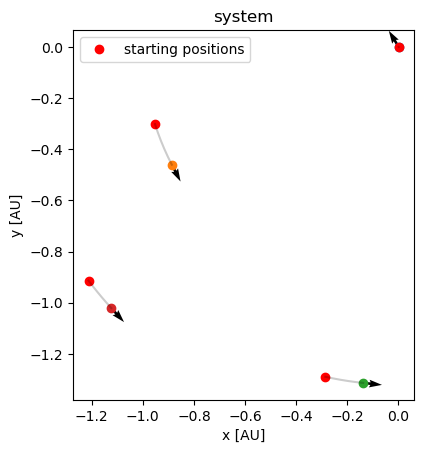

(4, 6, 4, 6)


In [10]:


plot_trajectory(systems[0], all_states[0])

print(all_states.shape)

It takes 2 minutes and 13 seconds to initialize and evolve 100 3 body systems for 30 days with n_step = 2. Now that we have our systems, we can continue with the next part: the optimizer.

## Using the optimizer
For every system, we now have 2 simulated data points which we can enter into the optimizer written by Andreas. I need to find out how it works now and use that to run it for each system. I imagine it will take a while.

In [11]:
# set directory to find the other code
import os
import tensorflow as tf
os.chdir('/Users/bjhnieuwhof/Google Drive/Universiteit Leiden/Master Astronomy/Master Research Project/Arbeit')
from Learning import NeuralODE as node
from Learning import BT_optimizer as bto



2024-11-14 15:05:24.837004: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:

# use the learn_masses_not_horizons function to learn da masses.
from tensorflow.keras.optimizers import Adam

# set the time parameters for the learning function
tau = 1 # in days
num_of_steps_in_do_step_between_costfunction_points = int(stepsize / tau)

print('evolve_time:', evolve_time)
print('n_steps in evolution with brutus:', n_steps)
# print('num_steps_in_do_step:', num_steps_in_do_step)
print('num_of_steps_in_do_step_between_costfunction_points:', num_of_steps_in_do_step_between_costfunction_points)
print('tau:', tau)
# 2 options for optimizer
optimizer = bto.BachelorThesisOptimizer(learning_rate=1e-3, shape=n_bodies, convergence_rate=1.0001)
adam = Adam(learning_rate=1e-2)

learned_masses = np.zeros((n_systems, n_bodies))
print('true masses (and initial guesses):', masses[:n_bodies])

masses_perturbed = masses * (1 + np.random.normal(0, 0.00000001, len(masses)))
print('perturbed masses:', masses_perturbed[:n_bodies])
for syst_index in range(len(systems_evolved)):
    # get the initial r and v of the starting system
    system = systems[syst_index]
    # extract r and v from the all_states array
    r = all_states[syst_index, :, :, :3]
    v = all_states[syst_index, :, :, 3:]
    # run the learning function
    system_masses = node.learn_masses_not_horizons_multible_intermediate_points(optimizer=
        bto.BachelorThesisOptimizer(learning_rate=1e-3, 
                                    shape=n_bodies, 
                                    convergence_rate=1.0001), 
                                       tau = tau, 
                                       n = n_bodies, 
                                       r = r, v = v,
                                       m = [1, 1, 1, 1],
                                       num_of_steps_in_do_step_between_costfunction_points = num_of_steps_in_do_step_between_costfunction_points,
                                       accuracy = 1e-30,
                                       negative_mass_penalty=10)
    learned_masses[syst_index] = system_masses[-1]
    print(f'learned masses for system {syst_index}:', system_masses[-1])


evolve_time: 10 day
n_steps in evolution with brutus: 5
num_of_steps_in_do_step_between_costfunction_points: 2
tau: 1
true masses (and initial guesses): [1.0, 0.001, 0.0001, 1e-05] MSun
perturbed masses: [1.00000001486, 0.00100000000237, 9.99999989762e-05, 9.9999999287e-06] 1.98892e+30 * kg
[ 1.002  0.998  0.998  0.998]
[ 1.006  0.994  0.994  0.994]
[ 1.014  0.986  0.986  0.986]
[ 1.03  0.97  0.97  0.97]
[ 1.062  0.938  0.938  0.938]
[ 1.126  0.874  0.874  0.874]
[ 1.094  0.746  0.746  0.746]
[ 1.062  0.49   0.49   0.49 ]
[ 0.9980064 -0.022     -0.022     -0.022    ]
[ 1.0300032  0.234      0.234      0.234    ]
[ 1.0140048  0.106      0.106      0.106    ]
[ 0.9980064 -0.022     -0.022     -0.022    ]
[ 1.0060056  0.042      0.042      0.042    ]
[ 1.002006  0.01      0.01      0.01    ]
[ 0.9980064 -0.022     -0.022     -0.022    ]
[ 1.0000062 -0.006     -0.006     -0.006    ]
[ 1.002006  0.01      0.01      0.01    ]
[ 1.0010061  0.002      0.002      0.002    ]
[ 1.00150605 -0.006 

Given an evolve_time of 10000 days and a timestep of 1 day, it takes 80 minutes to learn the masses of 1 4body system, although it seems to converge a bit before the 100th epoch. The learned masses are:

learned masses for system 0: [ 1.02448767  0.08364754  0.30390189  0.03315871]
learned masses for system 1: [  1.00216916e+00   1.00082425e-03   1.79218831e-02   9.48087453e-06]

So this is not correct, but i guess it's less wrong than previous cases? I think the large timestep is good. But it's still wrong :((.

The second one is almost correct! But I don't know why it's almost correct.

In [12]:
# try if the system evolves the same way with the learned masses. It doesn't!
# generate system with learned masses
# learnedmass_system = generate_n_body_system(n_bodies, phaseseed=0)
# for i in range(n_bodies):
#     learnedmass_system[i].mass = learned_masses[0][i] | units.MSun

# plot_system(learnedmass_system, title='initial system with learned masses')
# plot_system(systems[0], title='initial system with true masses')
# # evolve the system
# learnedmass_system_evolved = evolve_systems([learnedmass_system], evolve_time, n_steps)[0]
# plot_system(learnedmass_system_evolved, title='evolved system with learned masses')
# plot_system(systems_evolved[0], title='evolved system with true masses')

nan runs removed: 1


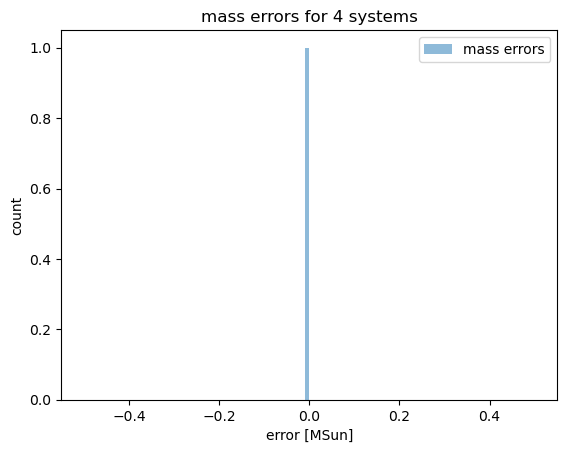

In [13]:
# remove systems with nan masses
learned_masses = learned_masses[~np.isnan(learned_masses).any(axis=1)]
print('nan runs removed:', len(learned_masses))

plt.title(f'mass errors for {n_bodies} systems')
plt.xlabel('error [MSun]')
plt.ylabel('count')
# calculate the geometric error in the mass phase space
mass_errors = np.linalg.norm((learned_masses - masses[:n_bodies].value_in(units.MSun)), axis=1)
plt.hist(mass_errors, bins=100, alpha=0.5, label='mass errors')
plt.legend()
plt.show()

learned_masses_4bodies = learned_masses

NameError: name 'learned_masses_3bodies' is not defined

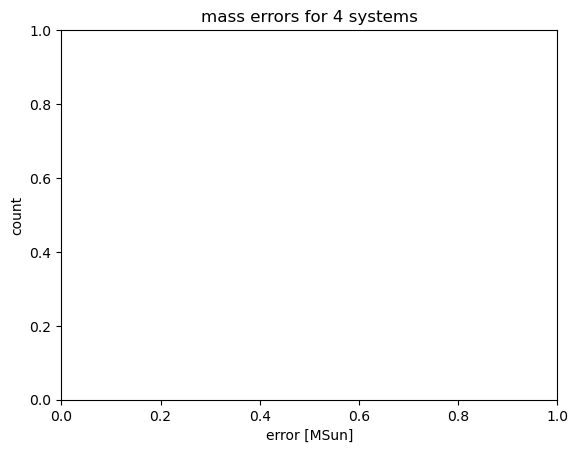

In [14]:
plt.title(f'mass errors for {n_bodies} systems')
plt.xlabel('error [MSun]')
plt.ylabel('count')
# calculate the geometric error in the mass phase space
mass_errors = np.linalg.norm((learned_masses_3bodies - masses[:n_bodies].value_in(units.MSun)), axis=1)
plt.hist(mass_errors, bins=100, alpha=0.5, label='mass errors')
plt.legend()
plt.show()